In [1]:
from qiskit import QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import QuantumRegister, Gate
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis
from qiskit.converters import circuit_to_dag
from qiskit.primitives import StatevectorEstimator
estimator_exact = StatevectorEstimator()

import numpy as np
pi = np.pi

from typing import Iterable, Optional

from IPython.display import clear_output
import matplotlib.pyplot as plt

from circuit_functions import ki_circ_as_list, bm_circ_as_list, gates_list_to_qc, single_qubit_pauli_rotation_in_generic_form
from circuit_functions import two_qubit_pauli_rotation_in_generic_form, gates_list_to_transpiled_circuit, connected_qubits

basis_gates = ['ecr','sx','x','rz']

In [2]:
coupling_map = np.load('calibration_data/coupling_map.npy')

# Experiment parameters

In [3]:
num_qubits = 10

central_qubit = 62
# device_qubits = list([central_qubit])
# for i in range(num_qubits-1):
#     connected_qubits_list = []
#     for q in device_qubits:
#         connected_qubits_list = connected_qubits_list + connected_qubits(q, coupling_map)
#     connected_qubits_list = [q for q in connected_qubits_list if q not in device_qubits]
#     new_qubit = np.random.choice(connected_qubits_list)
#     device_qubits.append(new_qubit)

device_qubits = [62, 63, 61, 64, 65, 54, 72, 66, 73, 45]

print('device_qubits =', device_qubits)

circuit_layers = [1,5,10,20]
num_different_layers = len(circuit_layers)

Ls = np.load('calibration_data/layers.npy')
gate_layers = [[],[],[]]
for i in range(3):
    for q0, q1 in Ls[i]:
        if q0 in device_qubits and q1 in device_qubits:
            gate_layers[i].append([device_qubits.index(q0), device_qubits.index(q1)])

nearest_neighbour_layers = gate_layers

num_benchmarking_reps = 10
observable = 'I'*device_qubits.index(62) + 'Z' + 'I'*(num_qubits-device_qubits.index(62)-1)
observable = observable[::-1]

qubits_to_correct = [device_qubits.index(62)]


benchmarking_circuits_per_layer = 10

noise_factors = [1,3,5]
num_noise_factors = len(noise_factors)

pauli_twirling_reps = 25

device_qubits = [62, 63, 61, 64, 65, 54, 72, 66, 73, 45]


# Set up noisy estimator

In [4]:
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from rb_prediction import calibration_csv_to_dict


# Create an empty noise model
noise_model = NoiseModel()
filename = 'calibration_data/ibm_brisbane_calibrations_2025-03-12T15_19_10Z.csv'
errors = calibration_csv_to_dict(filename, device_qubits)

In [5]:
for single_qubit_gate in ['sx','x']:
    for q in range(num_qubits):
        error = depolarizing_error(errors[single_qubit_gate][q], 1)
        noise_model.add_quantum_error(error, [single_qubit_gate], [q])

for layer in gate_layers:
    for q0, q1 in layer:
        error = depolarizing_error(errors['ecr'][(q0, q1)], 2)
        noise_model.add_quantum_error(error, ['ecr'], [q0, q1])

In [6]:
estimator_noisy = Estimator(
        options={
            'run_options': {'seed': 0},
            'backend_options': {'noise_model': noise_model, 'shots': 1024}
        }
    )

In [7]:
print(estimator_noisy.options)

Options(default_precision=0.0, backend_options={'noise_model': <NoiseModel on ['sx', 'x', 'ecr']>, 'shots': 1024}, run_options={'seed': 0})


# Building the passes

In [8]:
# Pauli twirling: taken from https://docs.quantum.ibm.com/guides/custom-transpiler-pass

class PauliTwirl(TransformationPass):
    """Add Pauli twirls to two-qubit gates."""
 
    def __init__(
        self,
        gates_to_twirl: Optional[Iterable[Gate]] = None,
    ):
        """
        Args:
            gates_to_twirl: Names of gates to twirl. The default behavior is to twirl all
                two-qubit basis gates, `cx` and `ecr` for IBM backends.
        """
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()
 
    def build_twirl_set(self):
        """
        Build a set of Paulis to twirl for each gate and store internally as .twirl_set.
        """
        self.twirl_set = {}
 
        # iterate through gates to be twirled
        for twirl_gate in self.gates_to_twirl:
            twirl_list = []
 
            # iterate through Paulis on left of gate to twirl
            for pauli_left in pauli_basis(2):
                # iterate through Paulis on right of gate to twirl
                for pauli_right in pauli_basis(2):
                    # save pairs that produce identical operation as gate to twirl
                    if (Operator(pauli_left) @ Operator(twirl_gate)).equiv(
                        Operator(twirl_gate) @ pauli_right
                    ):
                        twirl_list.append((pauli_left, pauli_right))
 
            self.twirl_set[twirl_gate.name] = twirl_list
 
    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:
        # collect all nodes in DAG and proceed if it is to be twirled
        twirling_gate_classes = tuple(
            gate.base_class for gate in self.gates_to_twirl
        )
        for node in dag.op_nodes():
            if not isinstance(node.op, twirling_gate_classes):
                continue
 
            # random integer to select Pauli twirl pair
            pauli_index = np.random.randint(
                0, len(self.twirl_set[node.op.name])
            )
            twirl_pair = self.twirl_set[node.op.name][pauli_index]
 
            # instantiate mini_dag and attach quantum register
            mini_dag = DAGCircuit()
            register = QuantumRegister(2)
            mini_dag.add_qreg(register)
 
            # apply left Pauli, gate to twirl, and right Pauli to empty mini-DAG
            mini_dag.apply_operation_back(
                twirl_pair[0].to_instruction(), [register[0], register[1]]
            )
            mini_dag.apply_operation_back(node.op, [register[0], register[1]])
            mini_dag.apply_operation_back(
                twirl_pair[1].to_instruction(), [register[0], register[1]]
            )
 
            # substitute gate to twirl node with twirling mini-DAG
            dag.substitute_node_with_dag(node, mini_dag)
 
        return dag

In [9]:
# Noise amplification

class AmplifyNoise(TransformationPass):
    def __init__(self, n):
        super().__init__()
        if n % 2 == 0:
            raise ValueError("n must be an odd integer.")
        self.n = n

    def run(self, dag):
        for node in dag.two_qubit_ops():
            original_gate = node.op
            qubits = node.qargs

            # Create the transformation circuit
            qc = QuantumCircuit(2)
            qc.append(original_gate, [0, 1])
            dagger_gate = original_gate.inverse()
            for _ in range(int((self.n-1)/2)):
                qc.append(dagger_gate, [0, 1])
                qc.append(original_gate, [0, 1])

            # Convert to a DAGCircuit for replacement
            replacement_dag = circuit_to_dag(qc)

            # Substitute the original node with the new DAGCircuit
            dag.substitute_node_with_dag(node, replacement_dag)

        return dag


In [10]:
# Amplify noise then apply Pauli Twirling

pass_managers = [
    PassManager([
        AmplifyNoise(factor), 
        PauliTwirl(), 
    ]) 
    for factor in noise_factors]

# Minimiser to perform ZNE

In [11]:
# Function to perform ZNE

import numpy as np
from scipy.optimize import curve_fit

def exponential_fit(x,a,b):
    return a * np.exp(b * x)

def estimate_f0(f1,f2,f3):
    x_data = np.array(noise_factors)
    y_data = np.array([f1,f2,f3])
    popt, _ = curve_fit(exponential_fit, x_data, y_data)
    a, b = popt
    return a

# Simulate kicked-Ising circuits

In [12]:
KI_circuits = []

for i in range(num_different_layers):
    ki_gates_list = ki_circ_as_list(num_qubits, circuit_layers[i], nearest_neighbour_layers, 0.01, 0.01, qubits_to_correct)
    ki_trans = gates_list_to_transpiled_circuit(ki_gates_list, num_qubits)
    KI_circuits.append(ki_trans)
    clear_output(wait=True)
    print(i)
clear_output(wait=True)
print('Done!')

Done!


In [13]:
# Simulate exact values, measuring Z_62

KI_exact_values = [estimator_exact.run([(qc,observable)]).result()[0].data.evs for qc in KI_circuits]
print(KI_exact_values)

[array(0.99995), array(0.99875251), array(0.99504108), array(0.98065146)]


In [14]:
import warnings
warnings.filterwarnings("ignore") # Ignore DepreciationWarnings temporarily

In [15]:
# KI_qem_results = [[[0 for i in range(pauli_twirling_reps)] for j in range(num_noise_factors)] for k in range(num_different_layers)]

# for i_layers in range(num_different_layers):
#     qc = KI_circuits[i_layers]

#     for i_noise_factor in range(num_noise_factors):
        
#         pm = pass_managers[i_noise_factor]
        
#         for i_pauli_rep in range(pauli_twirling_reps):

#             if KI_qem_results[i_layers][i_noise_factor][i_pauli_rep] == 0:
#                 # Parse circuit
#                 parsed_qc = pm.run(qc)
                
#                 # Noisy simulation of circuit
#                 qem_result = estimator_noisy.run([(parsed_qc, observable)]).result()[0].data.evs
#                 KI_qem_results[i_layers][i_noise_factor][i_pauli_rep] = qem_result     
    
#                 clear_output(wait=True)
#                 print('Done for ', i_layers, i_noise_factor, i_pauli_rep)
        
#         # Regularly save simulation results
#         np.save('ki_qem_results.npy', np.array(KI_qem_results, dtype=object))

In [16]:
KI_qem_results_np = np.load('job_data/ki_qem_results.npy', allow_pickle=True)
KI_qem_results = [[[0 for i in range(pauli_twirling_reps)] for j in range(num_noise_factors)] for l in range(num_different_layers)]

for i in range(num_different_layers):
    for k in range(num_noise_factors):       
        for l in range(pauli_twirling_reps):
            KI_qem_results[i][k][l] = float(KI_qem_results_np[i][k][l])

In [17]:
# Average over pauli twirling repetitions, then do ZNE

KI_extrapolated_qem_results = [0 for i in range(num_different_layers)]

for i_layers in range(num_different_layers):
        
    qem_results_fixed_qc = KI_qem_results[i_layers]
    f1,f3,f5 = [np.mean(x) for x in qem_results_fixed_qc]
    try:
        extrap_result = estimate_f0(f1,f3,f5)
    except:
        extrap_result = f1
        
    KI_extrapolated_qem_results[i_layers] = extrap_result

In [18]:
KI_averaged_qem_fidelities = [KI_extrapolated_qem_results[i]/KI_exact_values[i] for i in range(num_different_layers)]

In [19]:
print('Kicked Ising QEM fidelities:', KI_averaged_qem_fidelities)

Kicked Ising QEM fidelities: [1.0006287902489828, 0.9774398904973399, 0.9306093949430276, 0.8938556639308423]


# Simulate benchmarking circuits

In [20]:
# bm_qem_results = [[[[0 for i in range(pauli_twirling_reps)] for j in range(num_noise_factors)] for k in range(benchmarking_circuits_per_layer)] for l in range(num_different_layers)]

# for i_layers in range(4):

#     for i_reps in range(benchmarking_circuits_per_layer):
#         for i_noise_factor in range(num_noise_factors):
            
#             pm = pass_managers[i_noise_factor]
            
#             for i_pauli_rep in range(pauli_twirling_reps):
                
#                 # Parse circuit
#                 bm_gates_list = bm_circ_as_list(num_qubits, circuit_layers[i_layers], nearest_neighbour_layers, qubits_to_correct)
#                 qc = gates_list_to_transpiled_circuit(bm_gates_list, num_qubits)
#                 parsed_qc = pm.run(qc)

#                 # Noisy simulation of circuit
#                 qem_result = estimator_noisy.run([(parsed_qc, observable)]).result()[0].data.evs
#                 bm_qem_results[i_layers][i_reps][i_noise_factor][i_pauli_rep] = qem_result

#                 clear_output(wait=True)
#                 print('Done for ', i_layers, i_reps, i_noise_factor, i_pauli_rep)
        
#         # Regularly save simulation results
#         np.save('bm_qem_results.npy', np.array(bm_qem_results, dtype=object))

In [21]:
bm_qem_results_np = np.load('job_data/bm_qem_results.npy', allow_pickle=True)
bm_qem_results = [[[[0 for i in range(pauli_twirling_reps)] for j in range(num_noise_factors)] for k in range(benchmarking_circuits_per_layer)] for l in range(num_different_layers)]

for i in range(num_different_layers):
    for j in range(benchmarking_circuits_per_layer):
        for k in range(num_noise_factors):       
            for l in range(pauli_twirling_reps):
                bm_qem_results[i][j][k][l] = float(bm_qem_results_np[i][j][k][l])

In [22]:
# Average over pauli twirling repetitions, then do ZNE

bm_extrapolated_qem_results = [[0]*benchmarking_circuits_per_layer for i in range(num_different_layers)]

for i_layers in range(num_different_layers):
    for i_reps in range(benchmarking_circuits_per_layer):
        
        qem_results_fixed_qc = bm_qem_results[i_layers][i_reps]
        f1,f3,f5 = [np.mean(x) for x in qem_results_fixed_qc]
        
        try:
            extrap_result = estimate_f0(f1,f3,f5)
        except:
            extrap_result = 0
        bm_extrapolated_qem_results[i_layers][i_reps] = extrap_result
        clear_output(wait=True)
        print(i_layers, i_reps)

3 9


In [23]:
# Average over the 10 repetitions for each fixed number of layers
bm_averaged_qem_results = [abs(np.mean(x)) for x in bm_extrapolated_qem_results]
bm_averaged_qem_stds = [np.std(x) for x in bm_extrapolated_qem_results]
bm_yerr = [bm_averaged_qem_stds[:4],bm_averaged_qem_stds[:4]]

In [24]:
print('Benchmarked QEM fidelities:', bm_averaged_qem_results)

Benchmarked QEM fidelities: [0.994113145850922, 0.9701818610492138, 0.9377026052039794, 0.8955544332436389]


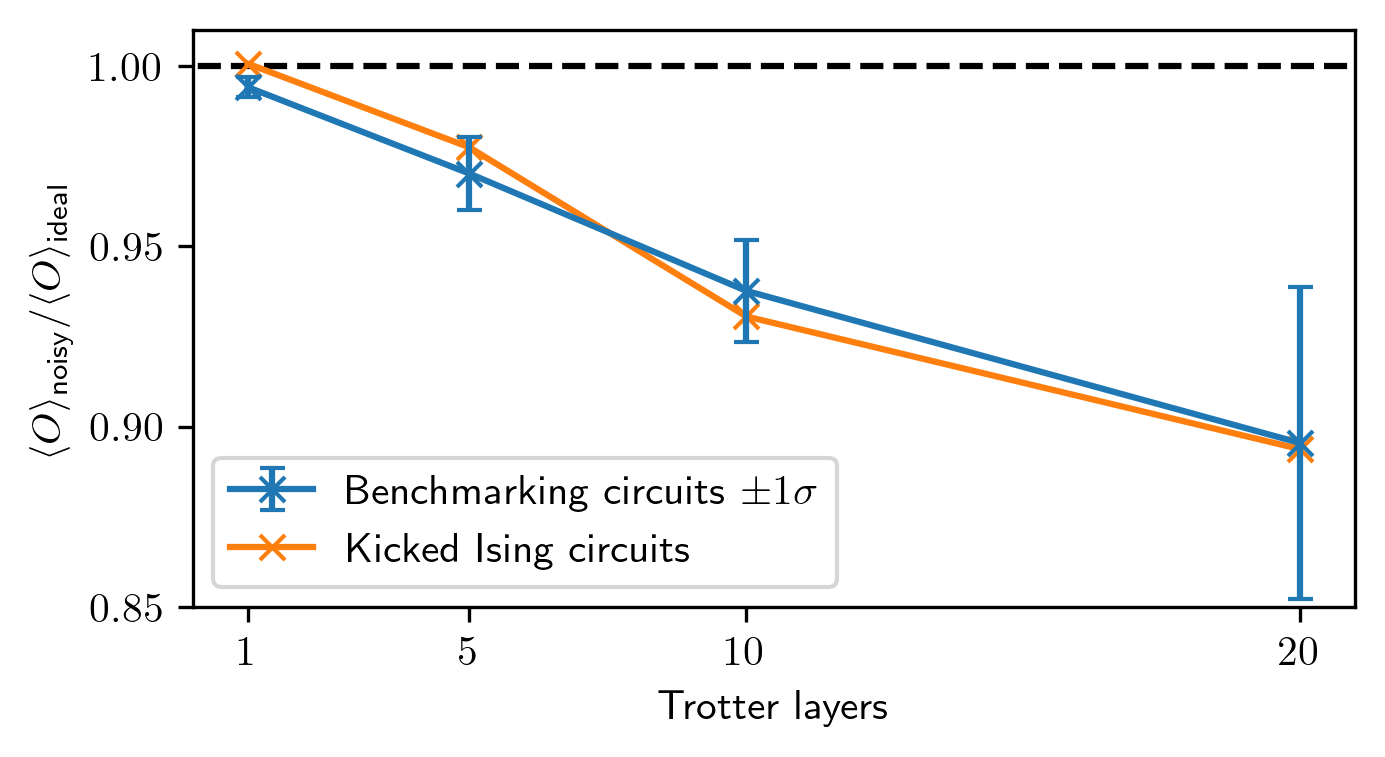

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'

plt.figure(dpi=300, figsize=(5,2.5))


plt.plot([-10, 30],[1,1],'--',color='black')


plt.plot(circuit_layers[:4], KI_averaged_qem_fidelities[:4], marker='x', color='tab:orange', label=r'Kicked Ising circuits')

plt.errorbar(circuit_layers[:4], bm_averaged_qem_results[:4], yerr=bm_yerr, marker='x', color='tab:blue', capsize=3, label=r'Benchmarking circuits $\pm 1\sigma$')

plt.ylim([0.5,1.2])
plt.xlabel('Trotter layers')
plt.ylabel(r'$\langle O \rangle_\text{noisy} / \langle O \rangle_\text{ideal}$')
plt.xticks(circuit_layers[:4]);



handles, labels = plt.gca().get_legend_handles_labels() 
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.ylim([0.85, 1.01])
plt.xlim([0, 21])
plt.savefig('10-qubit-qem-benchmarking.pdf', bbox_inches='tight')
plt.show()